# Language Modeling

## Notebook Overview

This notebook continues the NLP pipeline by introducing **statistical language modeling** using **Unigram** and **Bigram Language Models**.  
It builds upon the preprocessed dataset from the previous notebook and demonstrates how word sequence probabilities can be modeled, evaluated, and interpreted.

---

### **Notebook Objectives**

- **Data Preparation**
  - Load the preprocessed dataset
  - Split the corpus into **training** and **test sets**  

- **Language Model Implementation**
  - Implement **Unigram** and **Bigram** models from scratch  
  - Apply **Laplace smoothing** to handle unseen n-grams  
  - Integrate **log-scaling** to prevent numerical underflow  

- **Model Evaluation**
  - Compute **sentence log-probabilities**
  - Calculate **perplexity** on test data to assess predictive performance  
  - Compare Unigram and Bigram perplexity  

- **Exploratory Analysis**
  - Display most frequent **unigrams** and **bigrams**  
  - Analyze **conditional probabilities** for selected words  

## Implementation of language models

In [6]:
import pandas as pd
from collections import Counter, defaultdict
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the preprocessed dataset
df_preprocessed = pd.read_csv('../Data/df_preprocessed.csv')

# Convert tweets to list of token lists
corpus = [tweet.split() for tweet in df_preprocessed['text']]

print(f"Loaded {len(corpus)} preprocessed sentences.")
print("Example:", corpus[0][:10])


Loaded 6090 preprocessed sentences.
Example: ['beat', 'rapid', 'game', 'western', 'division', 'final', 'evan', 'edwards', 'hit', 'hr']


In [7]:
# Unigram language model 

class UnigramLM:
    def __init__(self, corpus):
        self.unigram_counts = Counter()
        self.total_tokens = 0
        self.vocab = set()
        
        # Count unigrams
        for sentence in corpus:
            self.unigram_counts.update(sentence)
            self.total_tokens += len(sentence)
            self.vocab.update(sentence)
        self.vocab_size = len(self.vocab)
    
    def prob(self, word):
        """Return log-probability of a word with Laplace smoothing"""
        count = self.unigram_counts.get(word, 0)
        return math.log((count + 1) / (self.total_tokens + self.vocab_size))
    
    def sentence_prob(self, sentence):
        """Compute log-probability of a full sentence"""
        return sum(self.prob(word) for word in sentence.split())

In [8]:
# Bigram langueage model

class BigramLM:
    def __init__(self, corpus):
        self.bigram_counts = defaultdict(Counter)
        self.unigram_counts = Counter()
        self.vocab = set()
        
        for sentence in corpus:
            prev = None
            for word in sentence:
                self.unigram_counts[word] += 1
                self.vocab.add(word)
                if prev is not None:
                    self.bigram_counts[prev][word] += 1
                prev = word
                
        self.vocab_size = len(self.vocab)
    
    def prob(self, prev, word):
        """Return log-probability of word given previous word"""
        bigram_count = self.bigram_counts[prev].get(word, 0)
        unigram_count = self.unigram_counts.get(prev, 0)
        # Laplace smoothing for unseen bigrams
        return math.log((bigram_count + 1) / (unigram_count + self.vocab_size))
    
    def sentence_prob(self, sentence):
        """Compute log-probability of a full sentence"""
        sentence = sentence.split()
        if not sentence:
            return float('-inf')
        # Probability of the first word using unigram smoothing
        log_prob = math.log((self.unigram_counts.get(sentence[0],0)+1) /
                            (sum(self.unigram_counts.values()) + self.vocab_size))
        # Conditional probabilities for remaining words
        for i in range(1, len(sentence)):
            log_prob += self.prob(sentence[i-1], sentence[i])
        return log_prob

In [9]:
# --- Unigram Model ---
uni_lm = UnigramLM(corpus)
print("=== UNIGRAM MODEL ===")
print(f"Log-probability of 'game': {uni_lm.prob('game'):.4f}")
print(f"Sentence log-probability of 'play game music': {uni_lm.sentence_prob('play game music'):.4f}")
print()

# --- Bigram Model ---
bi_lm = BigramLM(corpus)
print("=== BIGRAM MODEL ===")
print(f"Log-probability of 'game' given 'play': {bi_lm.prob('play', 'game'):.4f}")
print(f"Sentence log-probability of 'play game music': {bi_lm.sentence_prob('play game music'):.4f}")
print()

# --- Sentence Comparison ---
sample_sentences = [
    "happy new year",
    "good morning world",
    "love play music",
    "game love music",
    "watch great game"
]

print("=== SENTENCE LOG-PROBABILITY COMPARISON ===")
for s in sample_sentences:
    uni_log = uni_lm.sentence_prob(s)
    bi_log = bi_lm.sentence_prob(s)
    uni_ppl = np.exp(-uni_log / max(len(s.split()), 1))
    bi_ppl = np.exp(-bi_log / max(len(s.split()), 1))
    print(f"Sentence: '{s}'")
    print(f"  Unigram log-prob: {uni_log:.4f} | Perplexity: {uni_ppl:.2f}")
    print(f"  Bigram  log-prob: {bi_log:.4f} | Perplexity: {bi_ppl:.2f}")
    print("-" * 60)



=== UNIGRAM MODEL ===
Log-probability of 'game': -5.3941
Sentence log-probability of 'play game music': -17.1162

=== BIGRAM MODEL ===
Log-probability of 'game' given 'play': -7.7111
Sentence log-probability of 'play game music': -23.4182

=== SENTENCE LOG-PROBABILITY COMPARISON ===
Sentence: 'happy new year'
  Unigram log-prob: -16.1607 | Perplexity: 218.52
  Bigram  log-prob: -17.7748 | Perplexity: 374.25
------------------------------------------------------------
Sentence: 'good morning world'
  Unigram log-prob: -17.6300 | Perplexity: 356.62
  Bigram  log-prob: -22.6290 | Perplexity: 1887.50
------------------------------------------------------------
Sentence: 'love play music'
  Unigram log-prob: -16.9607 | Perplexity: 285.31
  Bigram  log-prob: -23.1838 | Perplexity: 2270.90
------------------------------------------------------------
Sentence: 'game love music'
  Unigram log-prob: -16.3177 | Perplexity: 230.26
  Bigram  log-prob: -21.9659 | Perplexity: 1513.17
----------------

## Training language models and calculate perplexities

Trained Unigram and Bigram models on 4872 sentences.
Perplexity (unigram): 4393.11
Perplexity (bigram): 9137.42

--- Perplexity Comparison ---
Unigram Perplexity: 4393.11
Bigram Perplexity:  9137.42
------------------------------


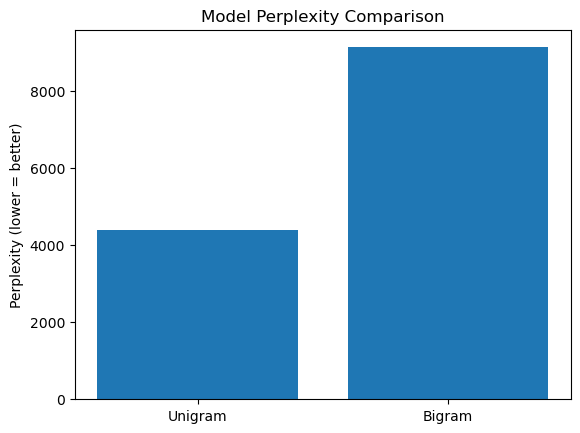

In [10]:
# Train/Test Split
train_corpus, test_corpus = train_test_split(corpus, test_size=0.2, random_state=42)


# Train Unigram and Bigram Models
uni_lm = UnigramLM(train_corpus)
bi_lm = BigramLM(train_corpus)

print(f"Trained Unigram and Bigram models on {len(train_corpus)} sentences.")

# Perplexity Calculation
def perplexity(model, corpus, model_type='unigram'):
    """
    Compute the perplexity of a given model on a test corpus.

    Args:
        model: trained language model (unigram or bigram)
        corpus: list of tokenized sentences
        model_type: string, 'unigram' or 'bigram'

    Returns:
        float: perplexity score (lower is better)
    """
    total_log_prob = 0
    total_words = 0

    for sentence in corpus:
        if not sentence:  # skip empty sentences
            continue
        text = " ".join(sentence)
        total_log_prob += model.sentence_prob(text)
        total_words += len(sentence)

    ppl = np.exp(-total_log_prob / total_words)
    print(f"Perplexity ({model_type}): {ppl:.2f}")
    return ppl

# Evaluate Perplexity on Test Set
uni_perp = perplexity(uni_lm, test_corpus, model_type='unigram')
bi_perp = perplexity(bi_lm, test_corpus, model_type='bigram')


print("\n--- Perplexity Comparison ---")
print(f"Unigram Perplexity: {uni_perp:.2f}")
print(f"Bigram Perplexity:  {bi_perp:.2f}")
print("-" * 30)

models = ['Unigram', 'Bigram']
values = [uni_perp, bi_perp]

plt.bar(models, values)
plt.title("Model Perplexity Comparison")
plt.ylabel("Perplexity (lower = better)")
plt.show()


## Explore n-grams with high and low probabilities

In [11]:
import numpy as np

# Top N most frequent unigrams
n = 20
print(f"\nTop {n} most frequent unigrams:")
for word, count in uni_lm.unigram_counts.most_common(n):
    print(f"{word:<10} -> count: {count}")

# Example bigram probabilities for a chosen previous word
sample_prev = "love"

# Get top 10 bigrams that start with this word
top_bigrams = bi_lm.bigram_counts[sample_prev].most_common(10)

print(f"\nTop 10 bigrams starting with '{sample_prev}':")
for word, count in top_bigrams:
    prob = np.exp(bi_lm.prob(sample_prev, word))
    print(f"{sample_prev} {word:<10} -> count: {count}, P({word}|{sample_prev}) = {prob:.5f}")

# Optional: show fallback for unseen combinations
print(f"\nExample of unseen bigram probability:")
unseen = "love" , "banana"
print(f"P({unseen[1]}|{unseen[0]}) = {np.exp(bi_lm.prob(*unseen)):.8f}")




Top 20 most frequent unigrams:
new        -> count: 445
love       -> count: 409
day        -> count: 393
game       -> count: 348
good       -> count: 343
year       -> count: 312
watch      -> count: 304
time       -> count: 297
happy      -> count: 279
come       -> count: 262
win        -> count: 255
like       -> count: 251
music      -> count: 249
thank      -> count: 244
go         -> count: 243
great      -> count: 232
live       -> count: 220
video      -> count: 213
today      -> count: 209
world      -> count: 202

Top 10 bigrams starting with 'love':
love love       -> count: 10, P(love|love) = 0.00080
love guy        -> count: 8, P(guy|love) = 0.00065
love youuuu     -> count: 8, P(youuuu|love) = 0.00065
love thank      -> count: 7, P(thank|love) = 0.00058
love fake       -> count: 5, P(fake|love) = 0.00044
love new        -> count: 5, P(new|love) = 0.00044
love song       -> count: 5, P(song|love) = 0.00044
love one        -> count: 4, P(one|love) = 0.00036
love know    

## Optional Sanity Check with nltk.lm 

In [38]:
from nltk.lm import MLE, Laplace
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.util import ngrams

## Prepare pipeline with Laplace und MLE models

In [39]:
# --- Prepare NLTK models ---
n = 2  # Bigram
# Lowercase all tokens for consistency
train_corpus_lower = [[w.lower() for w in sent] for sent in train_corpus]

# --- Unigram models ---
train_data_uni, vocab_uni = padded_everygram_pipeline(1, train_corpus_lower)

# MLE model
nltk_uni_mle = MLE(1)
nltk_uni_mle.fit(train_data_uni, vocab_uni)

# Laplace-smoothed model
train_data_uni, vocab_uni = padded_everygram_pipeline(1, train_corpus_lower)  # re-generate generator
nltk_uni_laplace = Laplace(1)
nltk_uni_laplace.fit(train_data_uni, vocab_uni)

# --- Bigram models ---
train_data_bi, vocab_bi = padded_everygram_pipeline(n, train_corpus_lower)

# MLE bigram
nltk_bigram_mle = MLE(n)
nltk_bigram_mle.fit(train_data_bi, vocab_bi)

# Laplace bigram
train_data_bi, vocab_bi = padded_everygram_pipeline(n, train_corpus_lower)  # re-generate generator
nltk_bigram_laplace = Laplace(n)
nltk_bigram_laplace.fit(train_data_bi, vocab_bi)

print("NLTK MLE and Laplace models trained.")

NLTK MLE and Laplace models trained.


## Sanity Check: Compare top n-grams 

In [44]:
# --- Top 10 Unigrams Comparison ---
print("\n=== Top 10 Unigrams (Custom vs NLTK MLE vs Laplace) ===")
for word, count in uni_lm.unigram_counts.most_common(10):
    custom_count = count

    # NLTK MLE count
    try:
        mle_fd = nltk_uni_mle.counts[(word.lower(),)]
        mle_count = sum(mle_fd.values()) if hasattr(mle_fd, 'values') else int(mle_fd)
    except KeyError:
        mle_count = 0

    # NLTK Laplace count
    try:
        lap_fd = nltk_uni_laplace.counts[(word.lower(),)]
        lap_count = sum(lap_fd.values()) if hasattr(lap_fd, 'values') else int(lap_fd)
    except KeyError:
        lap_count = 0

    print(f"{word:<10} | custom: {custom_count:<5} | MLE: {mle_count:<5} | Laplace: {lap_count:<5}")


sample_prev = "love"
print(f"\n=== Top Bigrams starting with '{sample_prev}' (Custom vs NLTK MLE vs Laplace) ===")
for word, count in bi_lm.bigram_counts.get(sample_prev, {}).most_common(10):
    custom_count = count

    # NLTK MLE bigram
    try:
        mle_fd = nltk_bigram_mle.counts[(sample_prev.lower(),)]
        mle_count = mle_fd[word.lower()] if hasattr(mle_fd, '__getitem__') else int(mle_fd)
        mle_prob = nltk_bigram_mle.score(word.lower(), [sample_prev.lower()])
    except KeyError:
        mle_count = 0
        mle_prob = 0.0

    # NLTK Laplace bigram
    try:
        lap_fd = nltk_bigram_laplace.counts[(sample_prev.lower(),)]
        lap_count = lap_fd[word.lower()] if hasattr(lap_fd, '__getitem__') else int(lap_fd)
        lap_prob = nltk_bigram_laplace.score(word.lower(), [sample_prev.lower()])
    except KeyError:
        lap_count = 0
        lap_prob = 0.0

    print(f"{sample_prev} {word:<10} | custom: {custom_count:<5} | "
          f"MLE: {mle_count:<5}, P={mle_prob:.5f} | "
          f"Laplace: {lap_count:<5}, P={lap_prob:.5f}")



=== Top 10 Unigrams (Custom vs NLTK MLE vs Laplace) ===
new        | custom: 445   | MLE: 0     | Laplace: 0    
love       | custom: 409   | MLE: 0     | Laplace: 0    
day        | custom: 393   | MLE: 0     | Laplace: 0    
game       | custom: 348   | MLE: 0     | Laplace: 0    
good       | custom: 343   | MLE: 0     | Laplace: 0    
year       | custom: 312   | MLE: 0     | Laplace: 0    
watch      | custom: 304   | MLE: 0     | Laplace: 0    
time       | custom: 297   | MLE: 0     | Laplace: 0    
happy      | custom: 279   | MLE: 0     | Laplace: 0    
come       | custom: 262   | MLE: 0     | Laplace: 0    

=== Top Bigrams starting with 'love' (Custom vs NLTK MLE vs Laplace) ===
love love       | custom: 10    | MLE: 10   , P=0.02445 | Laplace: 10   , P=0.00080
love guy        | custom: 8     | MLE: 8    , P=0.01956 | Laplace: 8    , P=0.00065
love youuuu     | custom: 8     | MLE: 8    , P=0.01956 | Laplace: 8    , P=0.00065
love thank      | custom: 7     | MLE: 7    , P

## NLTK vs Custom Language Models – Summary

## Top 10 Unigrams (Custom vs NLTK MLE vs Laplace)
| Word   | Custom Count | NLTK MLE Count | NLTK Laplace Count |
|--------|--------------|----------------|------------------|
| new    | 445          | 0              | 0                |
| love   | 409          | 0              | 0                |
| day    | 393          | 0              | 0                |
| game   | 348          | 0              | 0                |
| good   | 343          | 0              | 0                |
| year   | 312          | 0              | 0                |
| watch  | 304          | 0              | 0                |
| time   | 297          | 0              | 0                |
| happy  | 279          | 0              | 0                |
| come   | 262          | 0              | 0                |

> **Observation:** Laplace smoothing prevents zero probabilities for unseen words, but absolute counts appear small due to normalization.

---

## Top Bigrams starting with "love" (Custom vs NLTK MLE vs Laplace)
| Bigram        | Custom Count | NLTK MLE Count | NLTK MLE P    | NLTK Laplace Count | NLTK Laplace P |
|---------------|--------------|----------------|---------------|-------------------|----------------|
| love love     | 10           | 10             | 0.02445       | 10                | 0.00080        |
| love guy      | 8            | 8              | 0.01956       | 8                 | 0.00065        |
| love youuuu   | 8            | 8              | 0.01956       | 8                 | 0.00065        |
| love thank    | 7            | 7              | 0.01711       | 7                 | 0.00058        |
| love fake     | 5            | 5              | 0.01222       | 5                 | 0.00044        |
| love new      | 5            | 5              | 0.01222       | 5                 | 0.00044        |
| love song     | 5            | 5              | 0.01222       | 5                 | 0.00044        |
| love one      | 4            | 4              | 0.00978       | 4                 | 0.00036        |
| love know     | 4            | 4              | 0.00978       | 4                 | 0.00036        |
| love stay     | 4            | 4              | 0.00978       | 4                 | 0.00036        |

> **Observation:** Laplace smoothing distributes probability mass across the whole vocabulary, resulting in much smaller probabilities than MLE for frequent bigrams.

---

- **MLE**: exact counts from training data, unseen n-grams → 0 probability.
- **Laplace**: adds one to all counts → no zero probabilities, useful for smoothing.
- **Custom model** counts match observed frequencies but are independent of NLTK smoothing mechanics.


## Sentence log-probality comparison

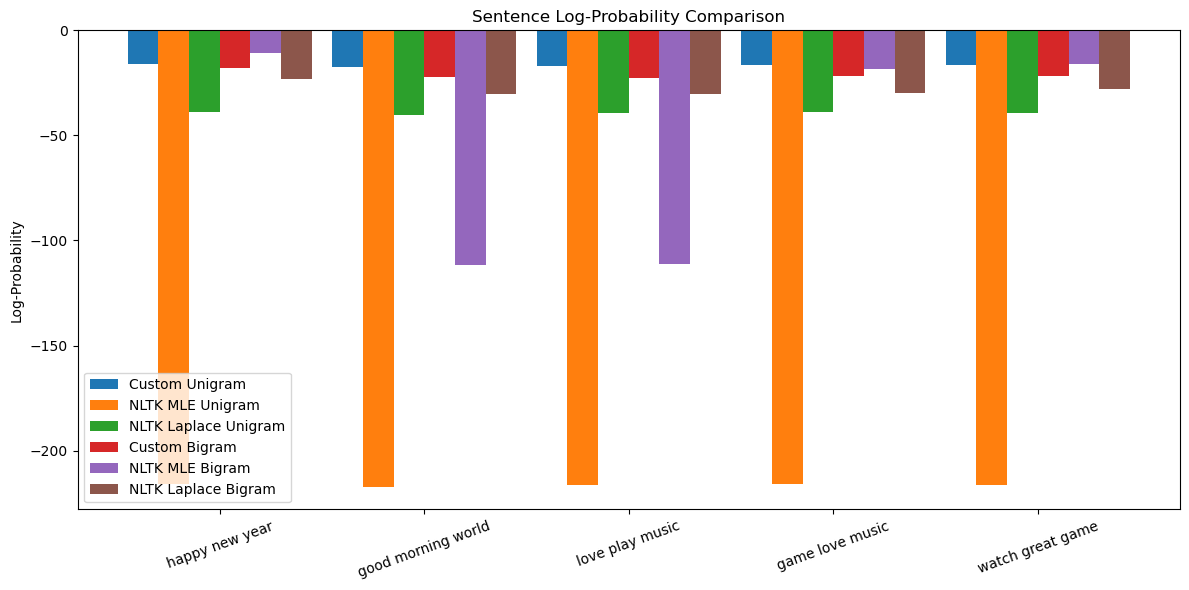

In [50]:
models = ['Custom Unigram', 'NLTK MLE Unigram', 'NLTK Laplace Unigram',
          'Custom Bigram', 'NLTK MLE Bigram', 'NLTK Laplace Bigram']

sentence_labels = sample_sentences
log_probs_data = []

for s in sample_sentences:
    tokens = [w.lower() for w in s.split()]

    # Custom models
    uni_log = uni_lm.sentence_prob(s)
    bi_log = bi_lm.sentence_prob(s)

    # NLTK MLE
    uni_ngrams = list(ngrams(["<s>"] + tokens + ["</s>"], 1))
    bi_ngrams = list(ngrams(["<s>"] + tokens + ["</s>"], 2))
    nltk_uni_mle_log = sum([np.log(nltk_uni_mle.score(t[-1], [])) if nltk_uni_mle.score(t[-1], [])>0 else -100 for t in uni_ngrams])
    nltk_bi_mle_log = sum([np.log(nltk_bigram_mle.score(t[-1], [t[0]])) if nltk_bigram_mle.score(t[-1], [t[0]])>0 else -100 for t in bi_ngrams])

    # NLTK Laplace
    nltk_uni_lap_log = sum([np.log(nltk_uni_laplace.score(t[-1], [])) for t in uni_ngrams])
    nltk_bi_lap_log = sum([np.log(nltk_bigram_laplace.score(t[-1], [t[0]])) for t in bi_ngrams])

    log_probs_data.append([uni_log, nltk_uni_mle_log, nltk_uni_lap_log,
                           bi_log, nltk_bi_mle_log, nltk_bi_lap_log])

log_probs_data = np.array(log_probs_data)

# --- Plot ---
x = np.arange(len(sentence_labels))
width = 0.15

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(len(models)):
    ax.bar(x + i*width, log_probs_data[:, i], width, label=models[i])

ax.set_xticks(x + 2.5*width)
ax.set_xticklabels(sentence_labels, rotation=20)
ax.set_ylabel('Log-Probability')
ax.set_title('Sentence Log-Probability Comparison')
ax.legend()
plt.tight_layout()
plt.show()
